# vtu to h5

In [1]:
from src.utils.commons import set_seed, get_config
import pyvista as pv
import numpy as np
from src.data.vtu_to_h5 import vtu_to_h5, rename_vtu_files, split_dataset_trajectories
import os

config = get_config('configs/paper.yaml')['config']
set_seed(10)

vtu_dir = config['dataset_dir']
h5_dir = os.path.join(config['split_dir'])


In [2]:
vtu_files =sorted([f for f in os.listdir(vtu_dir) if f.lower().endswith('.vtu')])
sorted_vtu_files = sorted(vtu_files, key=lambda x: int(x.split('_')[2]))
sorted_vtu_files = sorted(sorted_vtu_files,key=lambda x: (int(x.split('_')[2]), int(x.split('_')[4].split('.')[0])))
sorted_vtu_files[:5]

IndexError: list index out of range

## renamne the files based on the Re and then alpha

In [ ]:
rename_vtu_files(sorted_vtu_files, vtu_dir)

In [3]:
trajectory_numbers = len(sorted_vtu_files)
trajectory_numbers

NameError: name 'sorted_vtu_files' is not defined

In [5]:
# read one of the vtu file
new_vtu_files = os.listdir(vtu_dir)
vtu_file = os.path.join(vtu_dir, new_vtu_files[0])
grid = pv.UnstructuredGrid(vtu_file)



In [28]:
# get the coordinates of the nodes
coordinates = np.array(grid.points[:, 0:2], dtype=np.float32)
coordinates[:,0:2].shape

(14576, 2)

In [14]:
# Get edges from grid
edges = grid.extract_all_edges()
edge_points = edges.lines.reshape(-1, 3)[1:] # Skip first element which is line count
edge_index = edge_points[:,1:].reshape(2, -1) # Get pairs of connected points
print("Edge index shape:", edge_index.shape)
print("\nFirst few edges:")
print(edge_index.reshape(2, -1))

Edge index shape: (2, 28911)

First few edges:
[[    1     2     2 ...  7331  7330  7107]
 [ 7332  7332  7331 ... 14575 14575 14574]]


In [8]:
velocity = grid.point_data['Velocity']
velocity.shape

(14576, 3)

In [9]:
x_vel = velocity[:, 0]
x_vel[:10]

pyvista_ndarray([0.99999994, 0.9999997 , 0.99999934, 0.9999993 ,
                 0.9999999 , 1.000001  , 1.000001  , 0.99999624,
                 0.99998134, 0.9999496 ], dtype=float32)

In [23]:
trajectories_list = list(range(trajectory_numbers))
train_trajectories, val_trajectories = split_dataset_trajectories(trajectories_list, 0.1)
len(train_trajectories)
# len(val_trajectories)

39

In [17]:
os.path.splitext(new_vtu_files[0])

('configuration_1', '.vtu')

In [21]:
base_name = os.path.splitext(new_vtu_files[0])[0]
traj_num_str = ''.join(filter(str.isdigit, base_name))

In [22]:
''.join(filter(str.isdigit, base_name))

'1'

In [23]:
traj_num_str

'1'

## vtu to h5 transform

In [7]:
result = vtu_to_h5(vtu_dir, h5_dir, 
          train_ratio=0.1, overwrite=True)

Pass 1: Reading all VTU files and extracting data...


Reading VTUs: 100%|██████████| 399/399 [00:00<00:00, 559.39it/s]


Fitting scaler on training data of shape: torch.Size([568464, 1])
Scaler fitted. Applying to the entire dataset.
Scaler saved to ./dataset/rans_naca0012/incompressible/flow_split\scaler.pkl
Writing training data to ./dataset/rans_naca0012/incompressible/flow_split\train.h5 (39 trajectories)


Writing train.h5: 100%|██████████| 39/39 [00:00<00:00, 1005.48it/s]


Writing validation data to ./dataset/rans_naca0012/incompressible/flow_split\val.h5 (360 trajectories)


Writing val.h5: 100%|██████████| 360/360 [00:00<00:00, 1826.49it/s]

VTU to H5 conversion with scaling and splitting complete. Output in ./dataset/rans_naca0012/incompressible/flow_split


## Test h5

In [8]:
import h5py as h5
import os
from src.utils.commons import set_seed, get_config
config = get_config('configs/paper.yaml')['config']

test_file = h5.File(os.path.join(config['split_dir'], 'train.h5'), 'r')


In [9]:
file_keys = list(test_file.keys())
file_length = len(file_keys)

In [3]:
file_keys

['configuration_106',
 'configuration_111',
 'configuration_112',
 'configuration_114',
 'configuration_120',
 'configuration_143',
 'configuration_155',
 'configuration_173',
 'configuration_174',
 'configuration_184',
 'configuration_2',
 'configuration_206',
 'configuration_209',
 'configuration_215',
 'configuration_242',
 'configuration_25',
 'configuration_254',
 'configuration_27',
 'configuration_275',
 'configuration_277',
 'configuration_281',
 'configuration_332',
 'configuration_333',
 'configuration_340',
 'configuration_348',
 'configuration_351',
 'configuration_352',
 'configuration_366',
 'configuration_373',
 'configuration_379',
 'configuration_390',
 'configuration_398',
 'configuration_44',
 'configuration_48',
 'configuration_57',
 'configuration_66',
 'configuration_7',
 'configuration_79',
 'configuration_82']

In [10]:
test = test_file[file_keys[0]].keys()

In [11]:
test

<KeysViewHDF5 ['Ux', 'coordinates', 'edge_index']>

In [4]:
sorted([int(key.split('_')[1]) for key in file_keys])

IndexError: list index out of range

In [7]:
index = 10
trajectory = f'configuration_{train_trajectories[index]}'
var = 'Ux'
print(f"trajectory: {trajectory}, var: {var}")
data_val[trajectory][var][:].reshape(len(data_val[trajectory][var][:]), -1)

trajectory: configuration_119, var: Ux


array([[ 0.89853696],
       [ 0.89853696],
       [ 0.89853696],
       ...,
       [-0.60405632],
       [-0.89698121],
       [-0.01725416]])

In [22]:
import numpy as np
edge_list = data_val['configuration_0']['edge_index'][:] - 1
coordinates = data_val['configuration_0']['coordinates'][:]

np.sqrt(np.sum(np.abs(coordinates[edge_list[0]] - coordinates[edge_list[1]])**2, axis=1)).shape


(7786,)

In [ ]:
import scipy
import torch
mat_dir = 'dataset/gca_dataset/navier_stokes_unstructured.mat'
data_mat = scipy.io.loadmat(mat_dir)
variables = ['VX']

In [3]:
data_mat['E'].shape

(7786, 2)

In [ ]:
import numpy as np
np.min(data_mat['E'].reshape(2,-1)[0,:] - 1)
np.max(data_mat['E'].reshape(2,-1)[0,:] - 1)

np.uint16(2718)

In [ ]:
all_velocities = torch.tensor(data_mat[variables[0]])

In [ ]:
from src.data import scaling

scaled_vel = scaling.tensor_scaling(all_velocities, 4, 'standard')[1]
scaled_vel.shape

torch.Size([341, 2719, 1])

In [34]:
scaled_vel.reshape(all_velocities.shape[0], -1).shape

torch.Size([2719, 341])

In [5]:
data_mat['E'].shape

(7786, 2)

In [7]:
'xx' in data_mat.keys()

True

In [6]:
data_mat['xx'].shape

(2719, 341)

In [7]:
data_mat['VX'].shape

(2719, 341)

In [6]:
data_mat['VX'].shape

(2719, 341)

In [ ]:
from src.data.loader_paper import GraphDatasetPaper

dataset = GraphDatasetPaper(config = config, split = 'train')

In [7]:
dataset[0]

d:\TA\TA2\GAE-ROM\src\data\loader_paper.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr = torch.tensor(self.edge_features, dtype=torch.float64),
d:\TA\TA2\GAE-ROM\src\data\loader_paper.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_weight = torch.tensor(self.edge_weights, dtype=torch.float64))


Data(x=[15677, 1], edge_index=[2, 46522], edge_attr=[46522, 2], pos=[15677, 2], edge_weight=[46522])

In [ ]:
# making the split just like the paper in preprocessing.py



In [2]:
import scipy.io

data_mat = scipy.io.loadmat(mat_dir)
print(data_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'E', 'P', 'T', 'VX', 'VY', 'dof', 'xx', 'yy'])


In [4]:
data_mat['VX'].shape[1]
# data_mat['VY'].shape
# data_mat['E'].shape
# data_mat['xx'].shape
# data_mat['yy'].shape

341

In [7]:
x_vel = data_mat['VX']
edge_index = data_mat['E']

In [14]:
x_vel[:,2].shape

(2719,)

In [12]:
edge_index.reshape(2,-1)


(2, 7786)

In [7]:
#load h5 file
import h5py

with h5py.File(h5_dir, 'r') as f:
    print(f['configuration_0']['Ux'][:])

[8.79881277e-24 0.00000000e+00 0.00000000e+00 ... 4.16588059e+00
 4.16573888e+00 1.69209028e+01]


In [1]:
import src.data.loader as loader

root_dir = 'dataset/gca_dataset/navier_stokes_unstructured.mat'
dim_pde = 2 # 2D or 3D
variable = 'VX' # VX, VY, or [VX, VY]
n_comp = 1 # 1 or 2 (for stokes, we see VX and VY separately)

dataset = loader.LoadDatasetGCA(root_dir, variable, dim_pde, n_comp)

In [41]:
# xx : x coordinates of the nodes
# yy : y coordinates of the nodes
# U : velocity field
# E : edge index

dataset.dim
import numpy as np
import torch
# check if the x coordinates are the same for all the nodes, output only true or false
pos = torch.cat((dataset.xx[:, 0].unsqueeze(1), dataset.yy[:, 0].unsqueeze(1)), 1)
pos.shape
torch.index_select(pos, 0, dataset.E[:, 0])
# np.all(np.isclose(dataset.xx[:,0].numpy(), dataset.xx[:,150].numpy()))


tensor([[10.0000,  0.0000],
        [10.0000,  0.0000],
        [10.0000,  0.0000],
        ...,
        [34.3148,  2.8706],
        [29.7921,  6.6656],
        [21.7647,  3.3555]], dtype=torch.float64)

In [52]:
dataset.

AttributeError: 'LoadDatasetGCA' object has no attribute 'shape'

In [42]:
import numpy as np
mu1 = np.linspace(0.5, 2., 21)[::2]
mu2 = np.linspace(2., 0.5, 151)[::5]
mu_space = [mu1, mu2]

In [51]:
from itertools import product
params = torch.tensor(np.array(list(product(*mu_space))))
print(params.shape, mu_space[0].shape, mu_space[1].shape)
params

torch.Size([341, 2]) (11,) (31,)


tensor([[0.5000, 2.0000],
        [0.5000, 1.9500],
        [0.5000, 1.9000],
        [0.5000, 1.8500],
        [0.5000, 1.8000],
        [0.5000, 1.7500],
        [0.5000, 1.7000],
        [0.5000, 1.6500],
        [0.5000, 1.6000],
        [0.5000, 1.5500],
        [0.5000, 1.5000],
        [0.5000, 1.4500],
        [0.5000, 1.4000],
        [0.5000, 1.3500],
        [0.5000, 1.3000],
        [0.5000, 1.2500],
        [0.5000, 1.2000],
        [0.5000, 1.1500],
        [0.5000, 1.1000],
        [0.5000, 1.0500],
        [0.5000, 1.0000],
        [0.5000, 0.9500],
        [0.5000, 0.9000],
        [0.5000, 0.8500],
        [0.5000, 0.8000],
        [0.5000, 0.7500],
        [0.5000, 0.7000],
        [0.5000, 0.6500],
        [0.5000, 0.6000],
        [0.5000, 0.5500],
        [0.5000, 0.5000],
        [0.6500, 2.0000],
        [0.6500, 1.9500],
        [0.6500, 1.9000],
        [0.6500, 1.8500],
        [0.6500, 1.8000],
        [0.6500, 1.7500],
        [0.6500, 1.7000],
        [0.6

# Loader

In [1]:
import gc
import numpy as np
import torch
from itertools import product
from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from warnings import filterwarnings
from torch_geometric.loader import DataLoader
from src.training.train import train
from src.data.loader_paper import GraphDatasetPaper
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/paper.yaml')
set_seed(10)

train_dataset = GraphDatasetPaper(config = config['config'], split = 'train')
val_dataset = GraphDatasetPaper(config = config['config'], split = 'val')
device = get_device()

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1, 
                          shuffle=False,
                          num_workers=config['training']['num_workers'])

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=config['training']['batch_size'], 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])

mu1 = np.array([10e4, 15e4, 20e4, 25e4, 30e4, 35e4, 40e4, 45e4, 50e4, 55e4, 60e4, 65e4, 70e4, 75e4, 80e4, 85e4, 90e4, 95e4, 100e4])
mu2 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
mu_space = [mu1, mu2]
params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

num_graphs = train_dataset.num_graphs
model = GAE(config, num_graphs).to(device)

In [2]:
history = train(model = model, 
                device = device, 
                params = params, 
                train_loader = train_loader, 
                is_val = True,
                val_loader = val_loader, 
                save_best_model=False,
                config = config['training'])

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


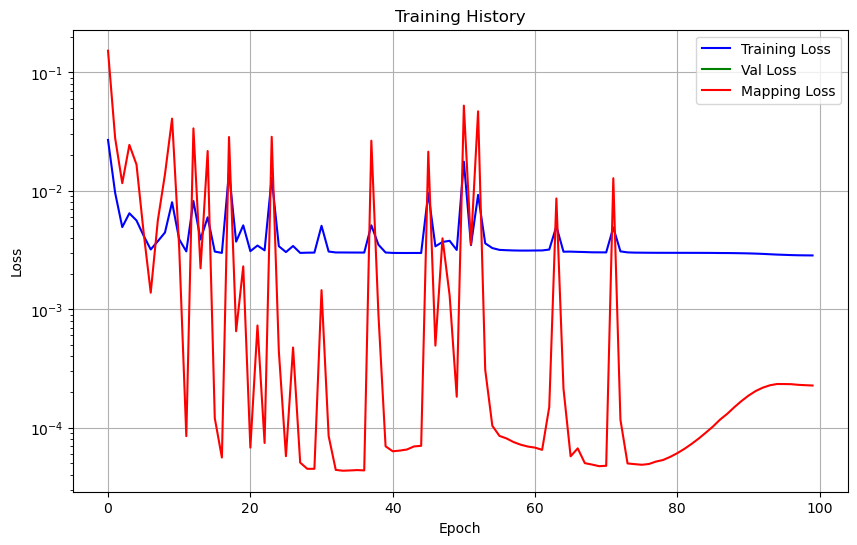

In [7]:
# plot the train history
import matplotlib.pyplot as plt

# Create figure and axis
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(history['train_loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss', color='green')
# Plot mapping loss if it exists and is non-zero
if any(history['map_loss']):
    plt.plot(history['map_loss'], label='Mapping Loss', color='red')

# Plot validation loss if it exists
if 'val_loss' in history and history['val_loss']:
    plt.plot(history['val_loss'], label='Validation Loss', color='green')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()


## IO Size test